# Курсовой проект

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Корректировка значений и заполнение пропусков

In [3]:
class DataPreprocessing:
    def __init__(self):
        self.current_year = datetime.now().year
        self.__medians = None
        self.__kitchen_quantil_975 = None
        self.__square_quantil_025 = None
    
    def fit(self, data):
        self.__medians = data.median()
        self.__kitchen_quantil_975 = data['KitchenSquare'].quantile(.975)
        self.__square_quantil_025 = data['Square'].quantile(.025)

        
    def transform(self, data):
        self.__transform_rooms(data)
        self.__transform_square(data)
        self.__transform_kitchen_square(data)
        self.__transform_floors(data)
        self.__transform_house_year(data)
        self.__fill_none(data)

        
    def __transform_rooms(self, data):
        data['Rooms_outlier'] = 0
        data.loc[(data['Rooms'] == 0) | (data['Rooms'] > 6), 'Rooms_outlier'] = 1
        data.loc[data['Rooms'] > 6, 'Rooms'] = self.__medians['Rooms']    
        
        
    def __transform_square(self, data):
        '''если  общая площадь меньше 025 квантиля то заполняем медианой'''
        data.loc[(data['Square'] < self.__square_quantil_025), 'Square'] = self.__medians['Square']
        
        
    def __transform_kitchen_square(self, data):
        '''минимальная площадь кухни 6м. если максимальная больше 975 квантиля то берём медиану'''
        min_square = 6
        data.loc[(data['KitchenSquare'] > self.__kitchen_quantil_975), 'KitchenSquare'] = self.__medians['KitchenSquare']
        data.loc[(data['KitchenSquare'] < min_square), 'KitchenSquare'] = min_square
        
        
    def __transform_floors(self, data):
        '''если этаж 0 или 99 или 117 то берём медиану'''
        data['HouseFloor_outlier'] = 0
        data.loc[(data['HouseFloor'] == 0) | (data['Floor'] > data['HouseFloor']), 'HouseFloor_outlier'] = 1
        data.loc[(data['HouseFloor'] == 0) | (data['HouseFloor'] == 99) | (data['HouseFloor'] == 117), 'HouseFloor'] = self.__medians['HouseFloor']

        floor_outliers = data.loc[data['Floor'] > data['HouseFloor']].index
        data.loc[floor_outliers, 'Floor'] = data.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))      
        
        
    def __transform_house_year(self, data):
        '''если год постройки больше текущего - берём текущий. если меньше 1900 то берём текущий'''
        data['HouseYear_outlier'] = 0
        data.loc[data['HouseYear'] > self.current_year, 'HouseYear_outlier'] = 1
        data.loc[(data['HouseYear'] > self.current_year) | (data['HouseYear'] < 1900), 'HouseYear'] = self.current_year
        
        
    def __fill_none(self, data):
        #LifeSquare
        data['LifeSquare_none'] = 0
        condition = (data['LifeSquare'].isna() | \
            (~data['LifeSquare'].isna() & data['LifeSquare'] > data['Square']) | \
            (~data['LifeSquare'].isna() & data['LifeSquare'] + data['KitchenSquare'] > data['Square']))
        data.loc[condition, 'LifeSquare_none'] = 1
        data.loc[condition, 'LifeSquare'] = data.loc[condition, 'Square'] - data.loc[condition, 'KitchenSquare'] - 3

#### Генерация новых признаков. От себя добавил только один. Больше добавлять не стал так как с новыми признаками модель ухудшала скор.

In [4]:
class FeatureGenerator:
    def __init__(self):
        self.median_price_by_district = None
        self.median_price_by_district_median = None
        self.median_price_by_floor_year = None
        self.median_price_by_floor_year_median = None
        self.square_by_district = None
        self.square_by_distric_median = None
        self.current_year = datetime.now().year
    
    def fit(self, data, y):
        df = data.copy()
        df['Price'] = y.values
        
        '''целевой признак район + количество комнат'''
        self.median_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False) \
                                          .agg({'Price': 'median'}) \
                                          .rename(columns={'Price': 'MedianPriceByDistrict'})
        self.median_price_by_district_median = self.median_price_by_district['MedianPriceByDistrict'].median()
        
        
        self.floor_max = df['Floor'].max()
        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)
        df['Price'] = y.values
        self.median_price_by_floor_year = df.groupby(['Floor_cat', 'HouseYear_cat'], as_index=False) \
                                            .agg({'Price':'median'}) \
                                            .rename(columns={'Price':'MedianPriceByFloorYear'})
        self.median_price_by_floor_year_median = self.median_price_by_floor_year['MedianPriceByFloorYear'].median()
        
        
        '''целевой признак район + площадь'''
        self.square_by_district = df.groupby(['DistrictId', 'Square'], as_index=False) \
                                          .agg({'Price': 'median'}) \
                                          .rename(columns={'Price': 'SquareByDistrict'})
        self.square_by_distric_median = self.square_by_district['SquareByDistrict'].median()        
        
        
    def generate(self, data):
        self.__a_b_maping(data)
        self.__lifeSquare_to_square(data)
        new_data = self.__generate_district(data)
        new_data = self.floor_to_cat(new_data)  
        new_data = self.year_to_cat(new_data)   
        new_data = self.__generate_MedianPriceByDistrict(new_data)
        new_data = self.__generate_MedianPriceByFloorYear(new_data)
        new_data = self.__generate_square_by_district(new_data)
        
        return new_data

    
    def __lifeSquare_to_square(self, data):
        data['LifeSquareSquare'] = data['LifeSquare'] / data['Square']
        
        
    def __a_b_maping(self, data):
        ab_map = {"A": 0, "B": 1}
        data['Ecology_2'] = data['Ecology_2'].replace(ab_map)
        data['Ecology_3'] = data['Ecology_3'].replace(ab_map)
        data['Shops_2'] = data['Shops_2'].replace(ab_map)
    
    
    def __generate_district(self, data):
        district_size = data['DistrictId'].value_counts() \
                                          .reset_index() \
                                          .rename(columns={"index": "DistrictId", "DistrictId": "DistrictSize"})
        new_data = data.merge(district_size, on='DistrictId', how='left')  
        new_data['IsDistrictLarge'] = 0
        new_data.loc[new_data['DistrictSize'] > 100, 'IsDistrictLarge'] = 1
        
        new_data['new_district'] = 0
        new_data.loc[new_data['DistrictSize'].isna(), 'new_district'] = 1
        new_data['DistrictSize'].fillna(5, inplace=True)
        
        return new_data
    
    
    def __generate_MedianPriceByDistrict(self, data):
        new_data = data.merge(self.median_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        new_data['MedianPriceByDistrict'].fillna(self.median_price_by_district_median, inplace=True)
        
        return new_data
    
    
    def __generate_MedianPriceByFloorYear(self, data):
        new_data = data.merge(self.median_price_by_floor_year, on=['Floor_cat', 'HouseYear_cat'], how='left')
        new_data['MedianPriceByFloorYear'].fillna(self.median_price_by_floor_year_median, inplace=True)
        
        return new_data
    
    def __generate_square_by_district(self, data):
        new_data = data.merge(self.square_by_district, on=['DistrictId', 'Square'], how='left')
        new_data['SquareByDistrict'].fillna(self.square_by_distric_median, inplace=True)
        
        return new_data
        
    
    def floor_to_cat(self, data):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        data['Floor_cat'] = pd.cut(data['Floor'], bins=bins, labels=False)
        data['Floor_cat'].fillna(-1, inplace=True) 
        
        return data
     
        
    def year_to_cat(self, data):
        bins = [0, 1941, 1945, 1960, 1980, 2000, 2010, 2020]
        data['HouseYear_cat'] = pd.cut(data['HouseYear'], bins=bins, labels=False)
        data['HouseYear_cat'].fillna(-1, inplace=True)
        
        return data    
        

In [5]:
train_df = pd.read_csv('c:\\test\\train.csv')
test_df = pd.read_csv('c:\\test\\test.csv')

#### Лучший скор получился с таким набором. 

In [6]:
features = [
            #'Rooms', 
            'Square', 
            'LifeSquare', 
            'KitchenSquare', 
            'Floor', 
            'HouseFloor', 
            'HouseYear', 
            'Ecology_1', 
            'Ecology_2', 
            'Ecology_3', 
            'Social_1', 
            'Social_2', 
            'Social_3', 
            'Helthcare_2', 
            'Shops_1', 
            'Shops_2'
           ]

new_features = [
                #'Rooms_outlier', 
                #'HouseFloor_outlier', 
                #'HouseYear_outlier', 
                #'LifeSquare_none', 
                #'DistrictSize',
                #'new_district', 
                #'IsDistrictLarge',  
                #'MedianPriceByDistrict', 
                'MedianPriceByFloorYear'#,
                #'LifeSquareSquare',
                #'SquareByDistrict'
               ]

target = 'Price'

#### Разделяем на обучающую и валидационную выборки

In [7]:
X = train_df.drop(columns=target)
y = train_df[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=22)

#### Корректируем значения тренировочной, валидационной и тестовой выборок

In [8]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)
preprocessor.transform(X_train)
preprocessor.transform(X_valid)
preprocessor.transform(test_df)
X_valid.shape, X_valid.shape, test_df.shape

((3300, 23), (3300, 23), (5000, 23))

#### Генерим новые признаки в тренировочной, валидационной и тестовой выборках

In [9]:
features_generator = FeatureGenerator()
features_generator.fit(X_train, y_train)

X_train = features_generator.generate(X_train)
X_valid = features_generator.generate(X_valid)
test_df = features_generator.generate(test_df)

X_valid.shape, X_valid.shape, test_df.shape

((3300, 32), (3300, 32), (5000, 32))

In [10]:
X_train = X_train[features + new_features]
X_valid = X_valid[features + new_features]
test_df = test_df[features + new_features]

#### Здесь пытался при помощи GridSearchCV подобрать параметры для RandomForestRegressor. Остановился на 
max_depth=16, 
max_features=5, 
n_estimators=1500, 
random_state=22

In [11]:
'''
print(f'start at {datetime.now().strftime("%H:%M:%S")}')
parameters = {
    'n_estimators': [500,1000,1500],
    'max_features': np.arange(5, 10),
    'max_depth': [2, 4, 8, 16]
}

clf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    scoring='r2',
    return_train_score=True,
    error_score="raise",
    cv=5,
    n_jobs=-1
)

clf.fit(X_train, y_train)
print(f'end at {datetime.now().strftime("%H:%M:%S")}')

best_n_estimators = clf.best_params_['n_estimators']
best_max_features = clf.best_params_['max_features']
best_max_depth = clf.best_params_['max_depth']
clf.best_params_
'''

'\nprint(f\'start at {datetime.now().strftime("%H:%M:%S")}\')\nparameters = {\n    \'n_estimators\': [500,1000,1500],\n    \'max_features\': np.arange(5, 10),\n    \'max_depth\': [2, 4, 8, 16]\n}\n\nclf = GridSearchCV(\n    estimator=RandomForestRegressor(),\n    param_grid=parameters,\n    scoring=\'r2\',\n    return_train_score=True,\n    error_score="raise",\n    cv=5,\n    n_jobs=-1\n)\n\nclf.fit(X_train, y_train)\nprint(f\'end at {datetime.now().strftime("%H:%M:%S")}\')\n\nbest_n_estimators = clf.best_params_[\'n_estimators\']\nbest_max_features = clf.best_params_[\'max_features\']\nbest_max_depth = clf.best_params_[\'max_depth\']\nclf.best_params_\n'

#### Обучаем модель и делаем predict. Побороть переобучаемость модели не удалось, при снижении переметров RandomForestRegressor падает R2. Выше 0.712 на валидационной выборке R2 вытянуть не удалось (на kaggle 0,723)

In [12]:
rfr_model = RandomForestRegressor(max_depth=16, 
                                  max_features=5, 
                                  n_estimators=1500, 
                                  random_state=22)
rfr_model.fit(X_train, y_train)
y_train_preds = rfr_model.predict(X_train)
y_test_preds = rfr_model.predict(X_valid)

print("Train R2: " + str(round(r2(y_train, y_train_preds), 3)))
print("Test R2:  " + str(round(r2(y_valid, y_test_preds), 3)))

Train R2: 0.949
Test R2:  0.711


Train R2:	0.949
Test R2:	0.711


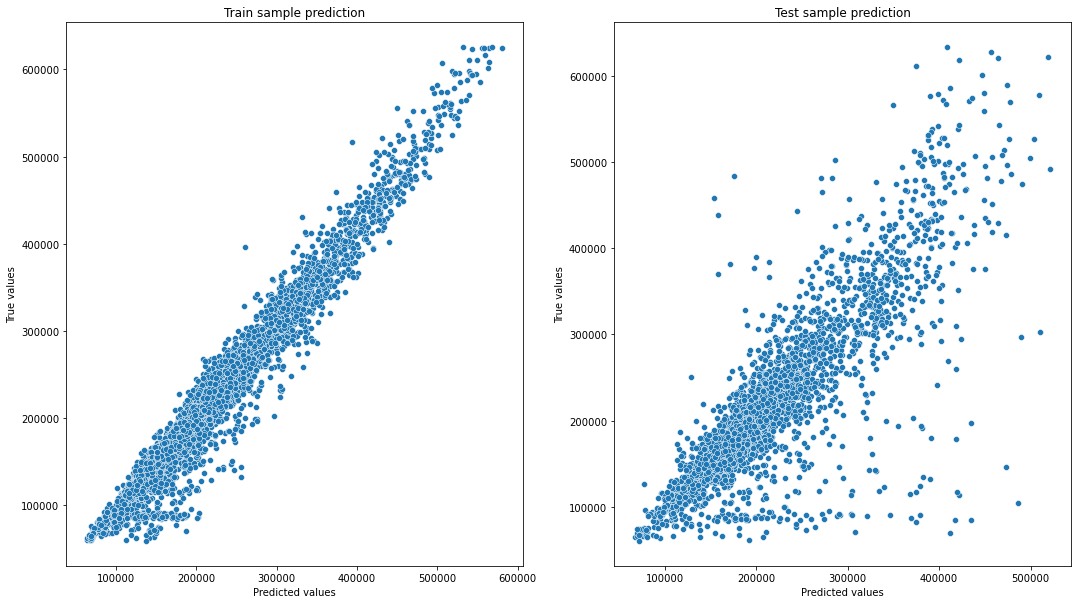

In [13]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Оценка важности признаков. Не смотря на явновыделяющийся Square без него R2 меньше.

Сумма всех показателей равна 0.9999999999999999


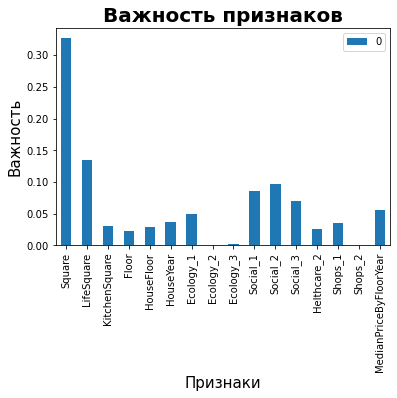

In [14]:
feats = {}
for feature_name, importance in zip(X_train[features + new_features], rfr_model.feature_importances_):
    feats[feature_name] = importance
    
feature_importsnce_df = pd.DataFrame.from_dict(feats, orient='index')
print(f"Сумма всех показателей равна {rfr_model.feature_importances_.sum()}")
feature_importsnce_df.plot(kind="bar")
plt.title('Важность признаков', fontsize=20, weight = 'bold')
plt.xlabel('Признаки', fontsize=15)
plt.ylabel('Важность', fontsize=15)
plt.show()

#### Кросс-валидация

In [15]:
cross_val_score(rfr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=22))

array([0.72849677, 0.73912653, 0.72584241])

#### Готовим submit

In [16]:
submit = pd.read_csv('c:\\test\\sample_submission.csv')
predictions = rfr_model.predict(test_df)
submit['Price'] = predictions
submit.to_csv('final_submit.csv', index=False)